In [34]:
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

import torchvision.models as models
import torchvision.transforms as transform

from PIL import Image

In [2]:
def load_image(path):
    img = Image.open(path)
    
    image_transformer = transform.Compose([
    transform.Resize(512),
    transform.ToTensor(),
])
    
    return image_transformer(img)

In [3]:
content_image = load_image("/kaggle/input/nst-images/content_image.jpg")
image_shape = content_image.shape
style_image = load_image("/kaggle/input/nst-images/style_image.jpg")

resizer = transform.Resize(content_image.permute(1,2,0).shape[:2])

style_image = resizer(style_image)

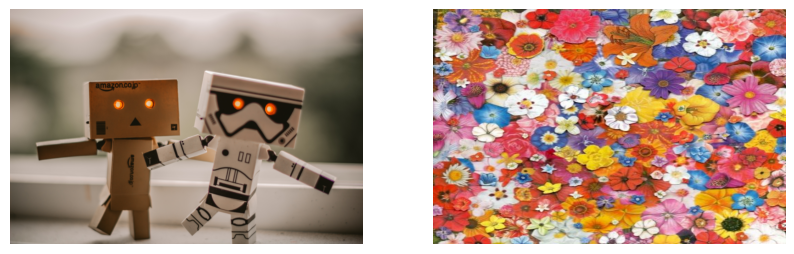

In [28]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2,1)
plt.axis('off')
plt.imshow(content_image.permute(1,2,0).cpu().numpy())

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(style_image.permute(1,2,0).cpu().numpy())


In [4]:
class VGG16(nn.Module):
    
    def __init__(self):
        super(VGG16, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.extracted_features = ['0', '5', '10', '19', '28']
        
    def forward(self, image):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        x = image.to(device)
        
        features = []
        
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            
            if name in self.extracted_features:
                features.append(x)
        
        return features

In [45]:
def content_loss_function(x, y):
    return nn.functional.mse_loss(x, y)

def gram_matrix(x, c, h, w):
    x = x.view(c, h*w)
    g = torch.mm(x, x.t())
    return g

def style_loss_function(x, y):
    c, h, w = x.shape
    generated_gram_matrix = gram_matrix(x, c, h, w)
    style_gram_matrix = gram_matrix(y, c, h, w)
    
    l = nn.functional.mse_loss(generated_gram_matrix, style_gram_matrix)
    
    return l /  (c * h * w)

In [46]:
iter = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image = []

model = VGG16()

# generated_image = torch.randn(3, content_image.shape[1], content_image.shape[2]).to(device).requires_grad_(True)
content_image = content_image.to(device)
style_image = style_image.to(device)
generated_image = style_image.clone().requires_grad_(True)

optimizer = optim.Adam([generated_image], lr=0.1)

alpha = 1
beta = 1000

for i in range(iter):
        
    generated_features = model(generated_image)
    content_features = model(content_image)
    style_features = model(style_image)
    
    content_loss = 0
    style_loss = 0
    
    image.append(generated_image.cpu().detach().permute(1,2,0).numpy())
    
    for gen, con, style in zip(generated_features, content_features, style_features):
        content_loss += content_loss_function(gen, con)
        style_loss += style_loss_function(gen, style)
    
    loss = content_loss * beta + alpha * style_loss 
    
    print("Epoch: " + str(i+1) + "\tStyle Loss: " + str(style_loss.cpu().detach().numpy()) + "\tContent Loss: " + str(content_loss.cpu().detach().numpy()) + "\tLoss: " + str(loss.cpu().detach().numpy()) )
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

image.append(generated_image.cpu().detach().permute(1,2,0).numpy())

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1	Style Loss: 0.0	Content Loss: 8.36201	Loss: 8362.01
Epoch: 2	Style Loss: 205.3042	Content Loss: 7.383864	Loss: 7589.168
Epoch: 3	Style Loss: 416.36755	Content Loss: 7.121576	Loss: 7537.9434
Epoch: 4	Style Loss: 534.9248	Content Loss: 6.858942	Loss: 7393.8667
Epoch: 5	Style Loss: 595.992	Content Loss: 6.5713935	Loss: 7167.3857
Epoch: 6	Style Loss: 624.3986	Content Loss: 6.3031507	Loss: 6927.5493
Epoch: 7	Style Loss: 633.0648	Content Loss: 6.0653157	Loss: 6698.381
Epoch: 8	Style Loss: 627.81165	Content Loss: 5.8457775	Loss: 6473.589
Epoch: 9	Style Loss: 612.43915	Content Loss: 5.641208	Loss: 6253.647
Epoch: 10	Style Loss: 590.1625	Content Loss: 5.450025	Loss: 6040.1875
Epoch: 11	Style Loss: 563.88885	Content Loss: 5.2654953	Loss: 5829.384
Epoch: 12	Style Loss: 535.4896	Content Loss: 5.0890265	Loss: 5624.516
Epoch: 13	Style Loss: 506.5027	Content Loss: 4.9182673	Loss: 5424.7695
Epoch: 14	Style Loss: 477.84866	Content Loss: 4.7544084	Loss: 5232.257
Epoch: 15	Style Loss: 450.2657	C

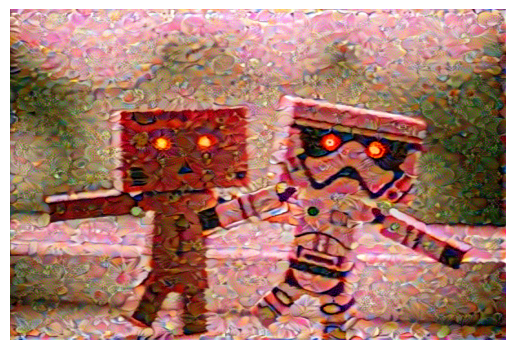

In [29]:
plt.axis("off")
plt.imshow(image[-1])

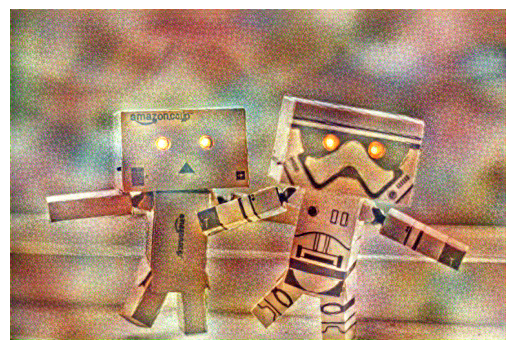

In [47]:
plt.axis('off')
plt.imshow(image[-1])